In [1]:
# load Google Driver
from google.colab import drive
import sys, os
drive.mount('/content/drive')

my_path = '/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence'
sys.path.append(my_path)
os.listdir(my_path)

Mounted at /content/drive


['dataTorchTransformLoad.py',
 'Resnet.py',
 'README.md',
 'VS_NET.py',
 'QuizDNN.py',
 'EVA5 Assignment 9a',
 'dataAlbumentationLoad.py',
 'Test_Train.py',
 'outputs',
 '__pycache__',
 'Plots.py',
 'GradCam.py',
 'grid_image.png',
 'Test_Train_OCP.py',
 '01-Super-convergence.ipynb',
 'best_model.pt',
 '02-Super-convergence.ipynb']

In [2]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import sys
import random
import matplotlib


# import for all the modular codes
import VS_NET
import Test_Train
import Test_Train_OCP
import Plots
import dataTorchTransformLoad as dtl
import Resnet
import GradCam
import Resnet
import dataAlbumentationLoad as dal
import GradCam
from GradCam import GradCAM, visualize_cam, save_misclassified, download_img_pil,pil_img_transform
from Plots import plot_misclassified,imshow


In [3]:
my_path

'/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence'

In [4]:
# def imshow(img):
#     # img = img / 2 + 0.5     # unnormalize
#     img[0] = img[0]*0.24703223 + 0.49139968
#     img[1] = img[1]*0.24348513 + 0.48215841
#     img[2] = img[2]*0.26158784 + 0.44653091
#     npimg = img.numpy()
#     image = np.transpose(npimg, (1, 2, 0))
#     plt.imshow(image)
#     plt.grid(b=None)
#     return image

def imshow1(img,c = "" ):
  #img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  fig = plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
  plt.title(c)
  plt.grid(b=None)
  plt.savefig(my_path+'/grid_image.png')

In [5]:

#initializers 
dropout_value = 0.05
num_splits=2
start_epoch=0
EPOCHS = 24
EPOCHS1 = 50
input_ch=3
best_acc = 85

metric_values = {}
models={}

batch_size_GPU=512
batch_size_CPU=16

model_save_path = my_path+"/best_model.pt"


In [6]:
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transform = dal.AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1 )
                                       ])
# # Test Phase transformations
test_transform = dal.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [7]:
# Transforms

transforms_cifar_train = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation((-5.0, 5.0),fill=1), 
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                           transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])
transforms_cifar_test = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        #   transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                        #   transforms.RandomHorizontalFlip(0.3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                          #  transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])

In [8]:
# download data

train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms_cifar_train)
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms_cifar_test) 

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=batch_size_GPU, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_CPU)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [10]:
len(test_loader), len(train_loader)

(20, 98)

In [11]:
10000/512, 50000/512

(19.53125, 97.65625)

In [12]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


<Figure size 432x288 with 0 Axes>

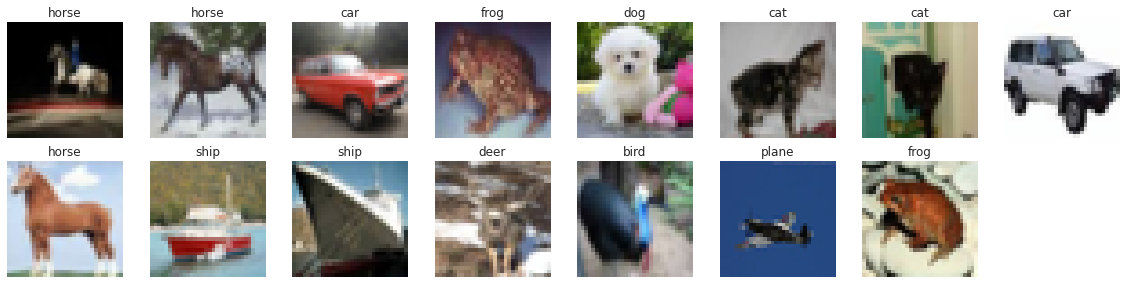

In [14]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# plt.style.use('dark_background')
figure = plt.figure()
plt.figure(figsize=(20,20))
num_of_images = 16
for index in range(1, num_of_images):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.title(classes[labels[index].item()])
    imshow(images[index])

#RESNET

In [15]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Resnet.ResNet18().to(device)

In [16]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


# LR Finder

In [ ]:
# !pip install torch_lr_finder
from torch_lr_finder import LRFinder

model = model
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=1e-05,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=98 ,step_mode="exp")


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.79E-03


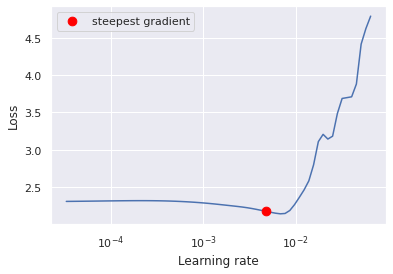

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd8613df278>,
 0.004790847768206475)

In [ ]:
lr_finder.plot(log_lr=True)

In [ ]:
ideal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
lr_finder.reset()

# Max LR Finder

use step scheduler to increase the learning rate from 0.0001 to 0.03 with 2 steps per epoch. 

Identify the learning rate with max accuracy. 

In [22]:
# LR Finder
ideal_lr=0.0001
# Uses Step lr to change the learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,nesterov=False)
scheduler = StepLR(optimizer, step_size=2, gamma=1.8)

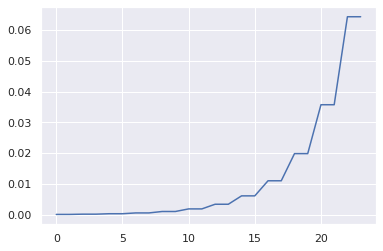

In [20]:
lr_list =[]
for i in range(EPOCHS):
  # print('EPOCH',i)
  # print(optimizer.param_groups[0]['lr'])
  lr_list.append(optimizer.param_groups[0]['lr'])
  optimizer.step()
  scheduler.step()
plt.plot(lr_list) 

In [23]:
exp_name = 'Best Learning Rate'

trainer = Test_Train_OCP.Trainer(model,device,train_loader,test_loader,optimizer,start_epoch,EPOCHS,scheduler,model_save_path,best_acc)
train_metric, test_metric,learning_rate = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary
metric_values[exp_name] = (train_metric, test_metric)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
learning rate  0.0001


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=2.173243284225464 Batch_id=97 Accuracy=15.16: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1723, Accuracy: 2204/10000 (22.04%)

emptying the cache
EPOCH: 1
learning rate  0.0001


Loss=2.034224033355713 Batch_id=97 Accuracy=23.33: 100%|██████████| 98/98 [00:57<00:00,  1.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.0251, Accuracy: 2701/10000 (27.01%)

EPOCH: 2
learning rate  0.00018


Loss=1.861476182937622 Batch_id=97 Accuracy=28.69: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8329, Accuracy: 3291/10000 (32.91%)

EPOCH: 3
learning rate  0.00018


Loss=1.7437689304351807 Batch_id=97 Accuracy=34.11: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7089, Accuracy: 3745/10000 (37.45%)

EPOCH: 4
learning rate  0.000324


Loss=1.6319639682769775 Batch_id=97 Accuracy=38.14: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5654, Accuracy: 4258/10000 (42.58%)

EPOCH: 5
learning rate  0.000324


Loss=1.531385898590088 Batch_id=97 Accuracy=42.00: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4851, Accuracy: 4505/10000 (45.05%)

EPOCH: 6
learning rate  0.0005832000000000001


Loss=1.3953074216842651 Batch_id=97 Accuracy=45.83: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3948, Accuracy: 4788/10000 (47.88%)

EPOCH: 7
learning rate  0.0005832000000000001


Loss=1.3227187395095825 Batch_id=97 Accuracy=50.08: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2810, Accuracy: 5286/10000 (52.86%)

EPOCH: 8
learning rate  0.0010497600000000003


Loss=1.177477478981018 Batch_id=97 Accuracy=53.42: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2269, Accuracy: 5534/10000 (55.34%)

EPOCH: 9
learning rate  0.0010497600000000003


Loss=1.1751501560211182 Batch_id=97 Accuracy=57.25: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1190, Accuracy: 5976/10000 (59.76%)

EPOCH: 10
learning rate  0.0018895680000000005


Loss=1.0860681533813477 Batch_id=97 Accuracy=59.87: 100%|██████████| 98/98 [00:57<00:00,  1.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0374, Accuracy: 6281/10000 (62.81%)

emptying the cache
EPOCH: 11
learning rate  0.0018895680000000005


Loss=0.9207165241241455 Batch_id=97 Accuracy=64.62: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9649, Accuracy: 6569/10000 (65.69%)

EPOCH: 12
learning rate  0.003401222400000001


Loss=0.8638883233070374 Batch_id=97 Accuracy=66.66: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0566, Accuracy: 6301/10000 (63.01%)

EPOCH: 13
learning rate  0.003401222400000001


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9041, Accuracy: 6804/10000 (68.04%)

EPOCH: 14
learning rate  0.006122200320000003


Loss=0.8171400427818298 Batch_id=97 Accuracy=71.57: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9970, Accuracy: 6716/10000 (67.16%)

EPOCH: 15
learning rate  0.006122200320000003


Loss=0.6698898673057556 Batch_id=97 Accuracy=74.83: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8736, Accuracy: 7045/10000 (70.45%)

EPOCH: 16
learning rate  0.011019960576000005


Loss=0.8267496228218079 Batch_id=97 Accuracy=74.30: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7700, Accuracy: 7299/10000 (72.99%)

EPOCH: 17
learning rate  0.011019960576000005


Loss=0.5844312310218811 Batch_id=97 Accuracy=77.85: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8985, Accuracy: 7056/10000 (70.56%)

EPOCH: 18
learning rate  0.01983592903680001


Loss=0.6707651615142822 Batch_id=97 Accuracy=76.53: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0556, Accuracy: 6603/10000 (66.03%)

EPOCH: 19
learning rate  0.01983592903680001


Loss=0.5381436347961426 Batch_id=97 Accuracy=79.79: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6396, Accuracy: 7811/10000 (78.11%)

EPOCH: 20
learning rate  0.035704672266240016


Loss=0.6595105528831482 Batch_id=97 Accuracy=78.15: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7234, Accuracy: 7657/10000 (76.57%)

emptying the cache
EPOCH: 21
learning rate  0.035704672266240016


Loss=0.5467677712440491 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8886, Accuracy: 7232/10000 (72.32%)

EPOCH: 22
learning rate  0.06426841007923204


Loss=0.6593674421310425 Batch_id=97 Accuracy=78.43: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7653, Accuracy: 7641/10000 (76.41%)

EPOCH: 23
learning rate  0.06426841007923204


Loss=0.43968695402145386 Batch_id=97 Accuracy=81.78: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]



Test set: Average loss: 0.5509, Accuracy: 8176/10000 (81.76%)



Best ACC and Learning Rate are 0.06426841007923204 81.782 0.06426841007923204


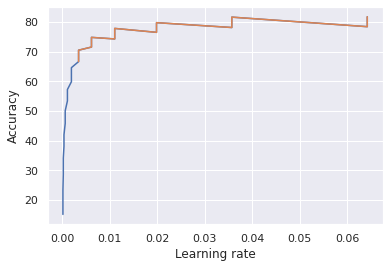

In [24]:
# plt the learning rate vs. accuracy. Get the best acc. 

(lr,acc) = learning_rate
plt.plot(lr,acc)
plt.plot(lr[12:],acc[12:]) # Zoom the plt a little bit. 
plt.ylabel('Accuracy')
plt.xlabel('Learning rate')
best_acc = lr[acc.index(max(acc))] # get the index where acc is max and get the learning rate of that index. 

print('Best ACC and Learning Rate are', max(lr), max(acc), best_acc)

Epochs = 24, 
batch size = 512
number of batchs per epoch = 50k/512 = 98

Max at 5 epochs - 5*98 = 490 step. 


# Learning Rate Finder - Increase the learning rate from low value to high value. 

Plot learning rate vs accuracy to come up with max learning rate. 

In [19]:
# one cycle LR

# best_acc=0.03

from torch.optim.lr_scheduler import OneCycleLR

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_acc, momentum=0.9, nesterov=False)

scheduler =OneCycleLR(optimizer, max_lr=best_acc, steps_per_epoch=1,
                      epochs=EPOCHS,div_factor = 100,final_div_factor=1,pct_start=5/EPOCHS,
                      anneal_strategy="linear")#,cycle_momentum=False,div_factor = 10, final_div_factor = 1)



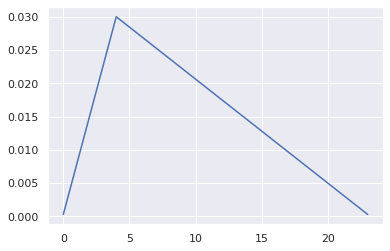

In [18]:
lr_list =[]
for i in range(EPOCHS):
  # print('EPOCH',i)
  # print(optimizer.param_groups[0]['lr'])
  lr_list.append(optimizer.param_groups[0]['lr'])
  optimizer.step()
  scheduler.step()
plt.plot(lr_list) 

In [20]:
exp_name = 'ONe cycle policy'

trainer = Test_Train_OCP.Trainer(model,device,train_loader,test_loader,optimizer,start_epoch,EPOCHS,scheduler,model_save_path,best_acc)
train_metric, test_metric,learning_rate = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary
metric_values[exp_name] = (train_metric, test_metric)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
learning rate  0.0003


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=1.783820390701294 Batch_id=97 Accuracy=24.40: 100%|██████████| 98/98 [00:55<00:00,  1.75it/s]



Test set: Average loss: 1.8057, Accuracy: 3313/10000 (33.13%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
emptying the cache
EPOCH: 1
learning rate  0.007724999999999999


Loss=1.2119290828704834 Batch_id=97 Accuracy=46.79: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 1.3327, Accuracy: 5247/10000 (52.47%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 2
learning rate  0.015149999999999999


Loss=1.0663745403289795 Batch_id=97 Accuracy=60.41: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 1.1916, Accuracy: 5926/10000 (59.26%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 3
learning rate  0.022574999999999998


Loss=0.7375130653381348 Batch_id=97 Accuracy=68.42: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]



Test set: Average loss: 1.2943, Accuracy: 5767/10000 (57.67%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 4
learning rate  0.03


Loss=0.7022780776023865 Batch_id=97 Accuracy=73.75: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.7590, Accuracy: 7364/10000 (73.64%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 5
learning rate  0.028436842105263156


Loss=0.5854155421257019 Batch_id=97 Accuracy=77.14: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.7137, Accuracy: 7591/10000 (75.91%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 6
learning rate  0.026873684210526314


Loss=0.676079273223877 Batch_id=97 Accuracy=80.16: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.8254, Accuracy: 7459/10000 (74.59%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 7
learning rate  0.025310526315789474


Loss=0.5961695313453674 Batch_id=97 Accuracy=82.07: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.6903, Accuracy: 7716/10000 (77.16%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 8
learning rate  0.02374736842105263


Loss=0.5452700853347778 Batch_id=97 Accuracy=84.05: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.5728, Accuracy: 8132/10000 (81.32%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 9
learning rate  0.02218421052631579


Loss=0.382551372051239 Batch_id=97 Accuracy=85.29: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.5988, Accuracy: 8075/10000 (80.75%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 10
learning rate  0.02062105263157895


Loss=0.3192235827445984 Batch_id=97 Accuracy=86.98: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.5767, Accuracy: 8138/10000 (81.38%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
emptying the cache
EPOCH: 11
learning rate  0.019057894736842107


Loss=0.3686011731624603 Batch_id=97 Accuracy=87.91: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.5973, Accuracy: 8157/10000 (81.57%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 12
learning rate  0.017494736842105264


Loss=0.28764110803604126 Batch_id=97 Accuracy=89.16: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.5443, Accuracy: 8350/10000 (83.50%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 13
learning rate  0.01593157894736842


Loss=0.29072490334510803 Batch_id=97 Accuracy=90.02: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.5284, Accuracy: 8401/10000 (84.01%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 14
learning rate  0.014368421052631579


Loss=0.25943318009376526 Batch_id=97 Accuracy=90.75: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.5312, Accuracy: 8421/10000 (84.21%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 15
learning rate  0.012805263157894736


Loss=0.1873580366373062 Batch_id=97 Accuracy=91.64: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.5856, Accuracy: 8373/10000 (83.73%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 16
learning rate  0.011242105263157897


Loss=0.23166929185390472 Batch_id=97 Accuracy=92.60: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.4840, Accuracy: 8574/10000 (85.74%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 17
learning rate  0.009678947368421054


Loss=0.20614047348499298 Batch_id=97 Accuracy=93.43: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.7576, Accuracy: 8022/10000 (80.22%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 18
learning rate  0.008115789473684212


Loss=0.21364696323871613 Batch_id=97 Accuracy=94.02: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.4777, Accuracy: 8619/10000 (86.19%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 19
learning rate  0.006552631578947369


Loss=0.12510015070438385 Batch_id=97 Accuracy=94.73: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.4999, Accuracy: 8573/10000 (85.73%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 20
learning rate  0.00498947368421053


Loss=0.13880905508995056 Batch_id=97 Accuracy=95.40: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.4268, Accuracy: 8757/10000 (87.57%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
emptying the cache
EPOCH: 21
learning rate  0.003426315789473687


Loss=0.109647236764431 Batch_id=97 Accuracy=95.97: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.4335, Accuracy: 8724/10000 (87.24%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 22
learning rate  0.0018631578947368443


Loss=0.08147221058607101 Batch_id=97 Accuracy=96.58: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.4008, Accuracy: 8834/10000 (88.34%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 23
learning rate  0.00030000000000000165


Loss=0.10282047837972641 Batch_id=97 Accuracy=96.96: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.3776, Accuracy: 8911/10000 (89.11%)

...BEST MODEL...
Save success...


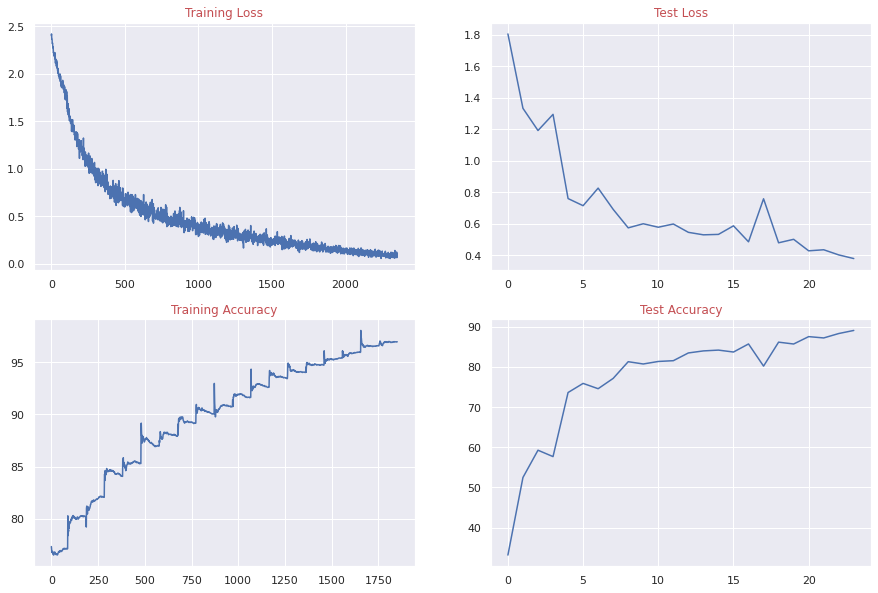

In [22]:
Plots.plot_metrics(train_metric, test_metric)

# Plot misclassified

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


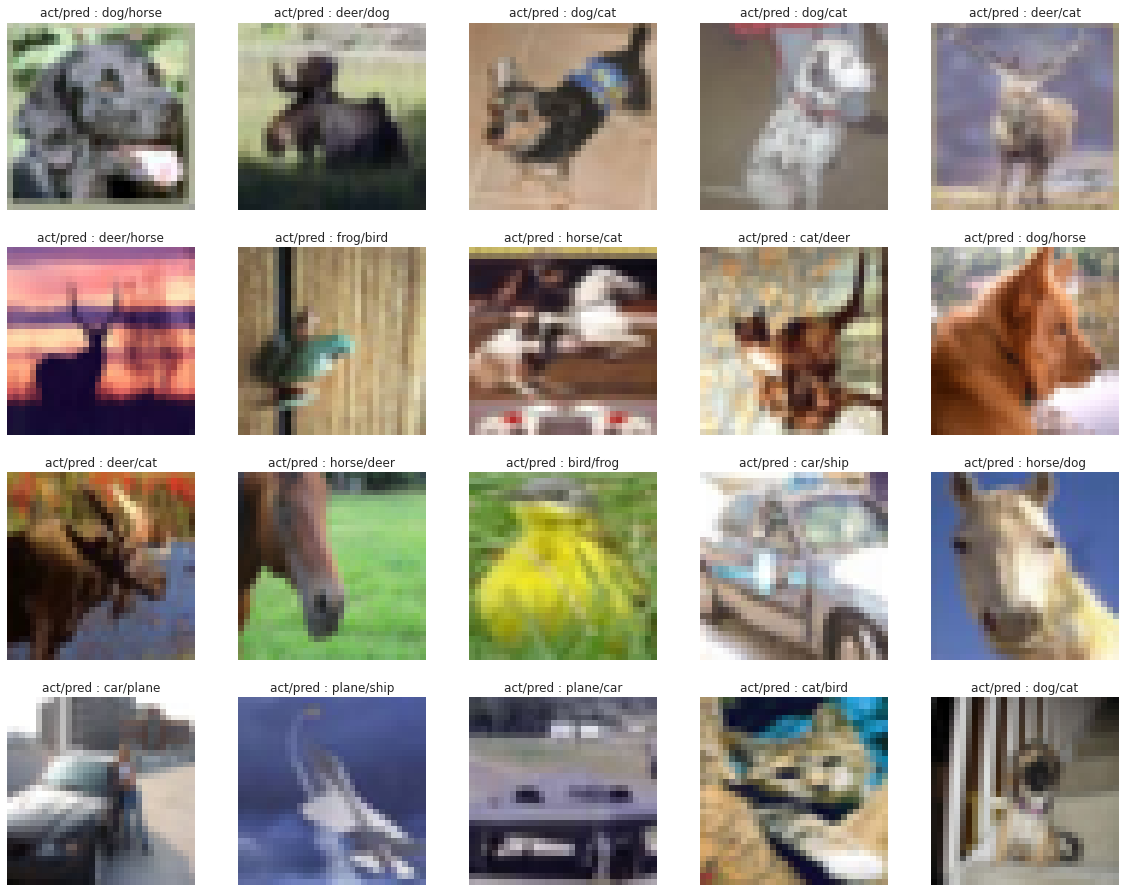

In [23]:
misclass_img_list = plot_misclassified(model, test_loader, device,classes)

In [24]:
len(misclass_img_list)

20

In [25]:
mis_img_name_list = save_misclassified(misclass_img_list)
pil_image = download_img_pil(mis_img_name_list)
torch_img_list,normed_torch_img = pil_img_transform(pil_image,device)

In [26]:
len(mis_img_name_list), len(pil_image), len(torch_img_list)

(20, 20, 20)

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


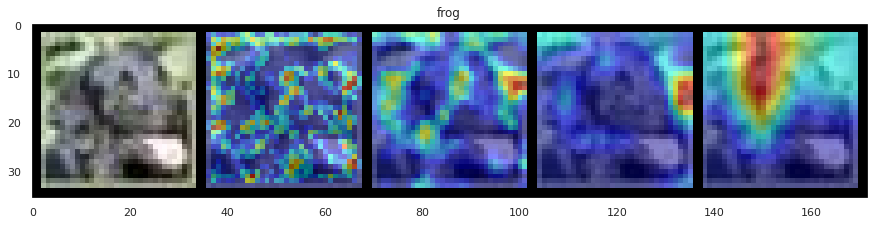

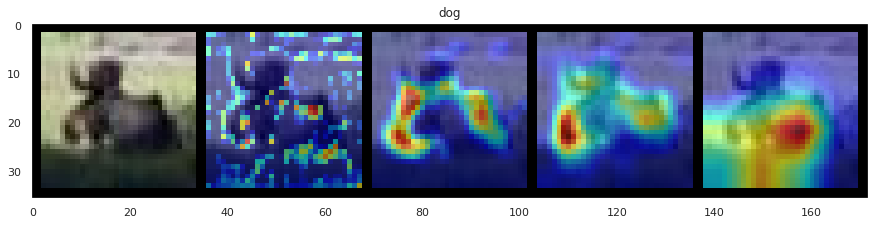

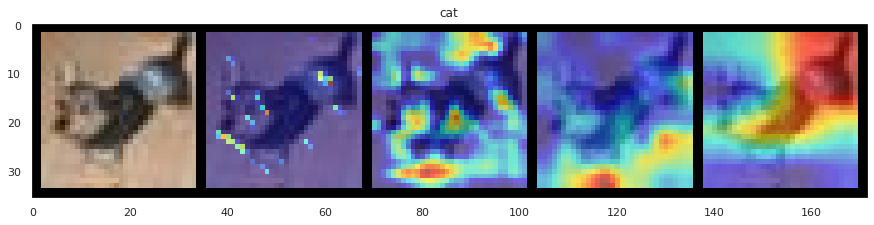

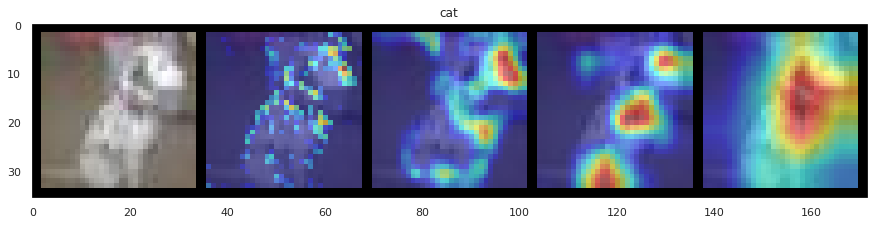

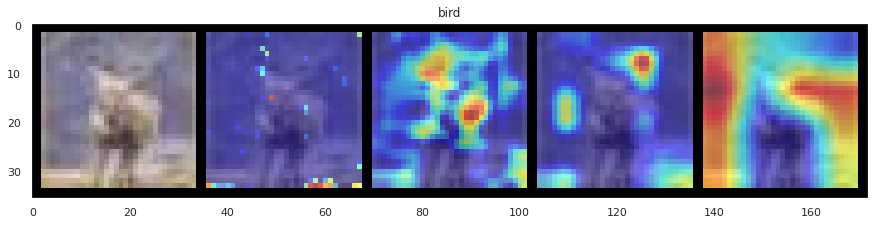

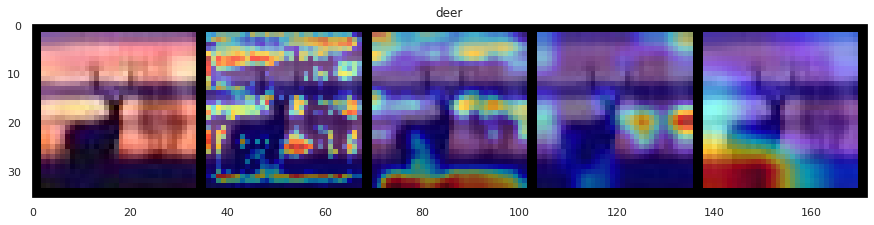

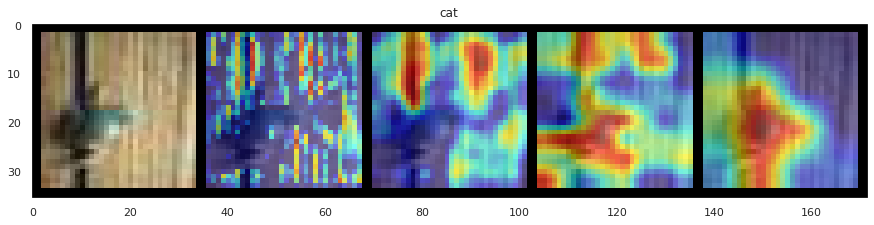

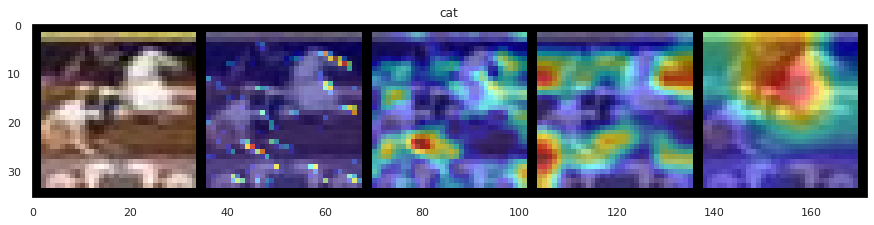

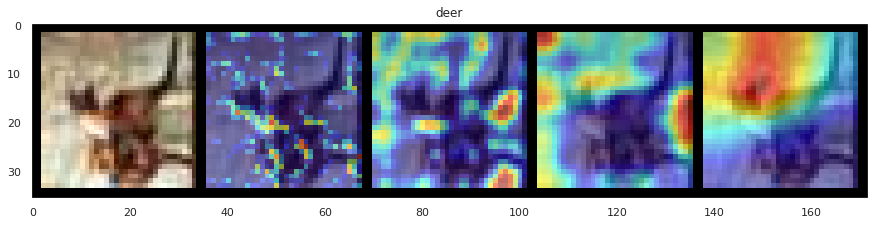

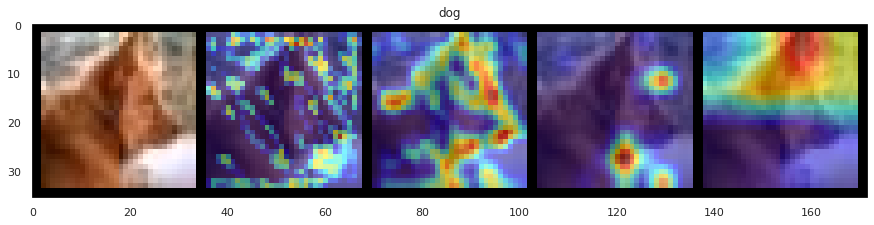

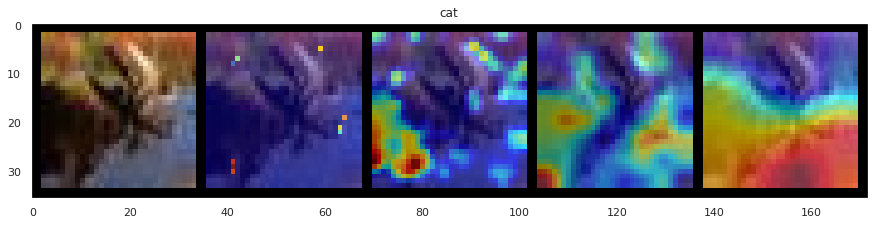

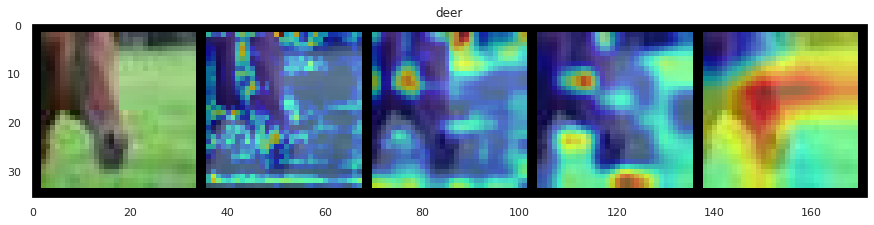

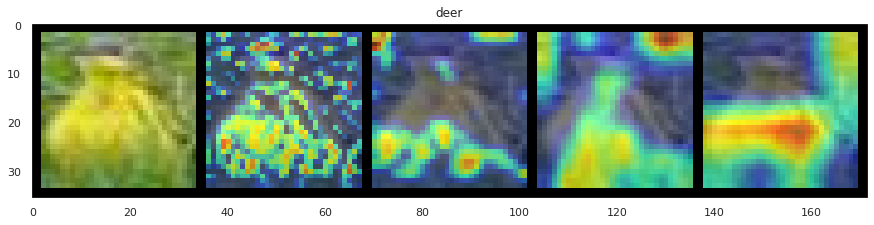

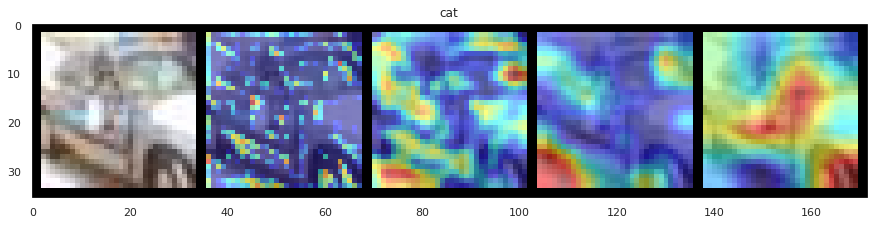

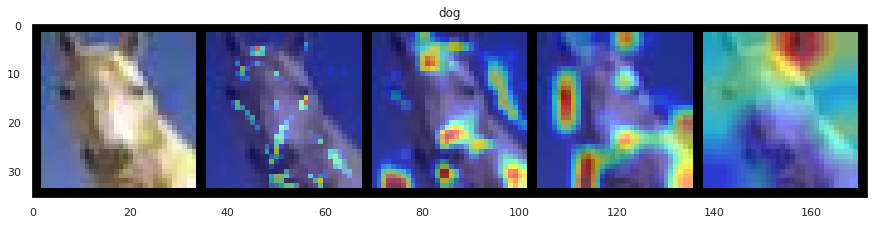

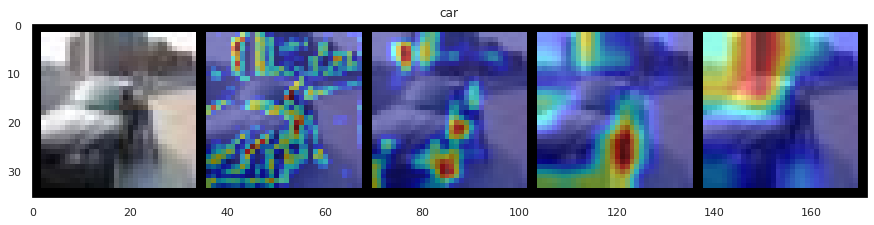

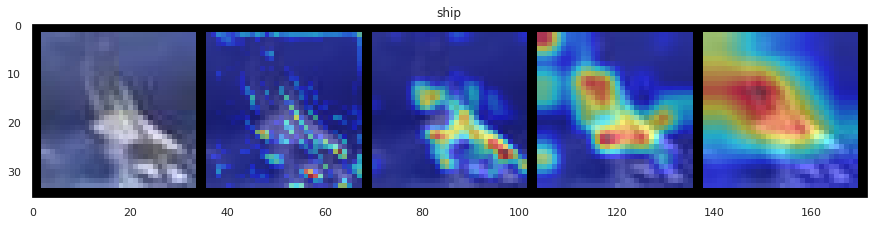

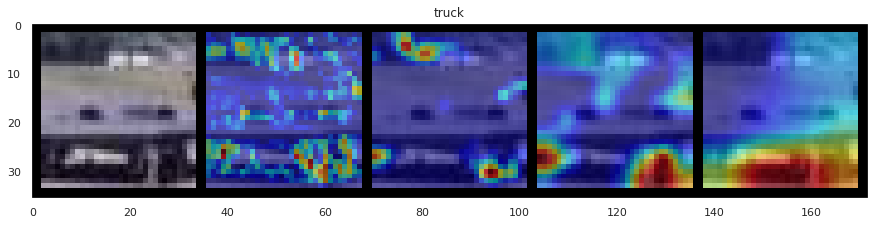

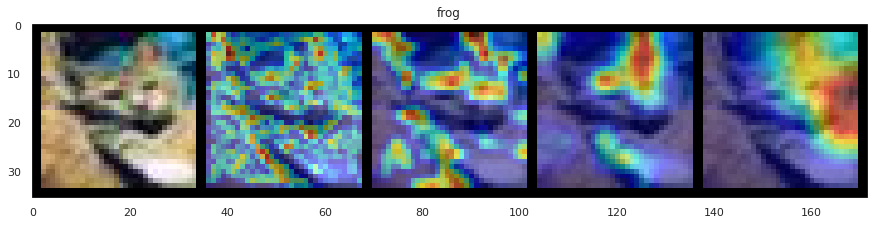

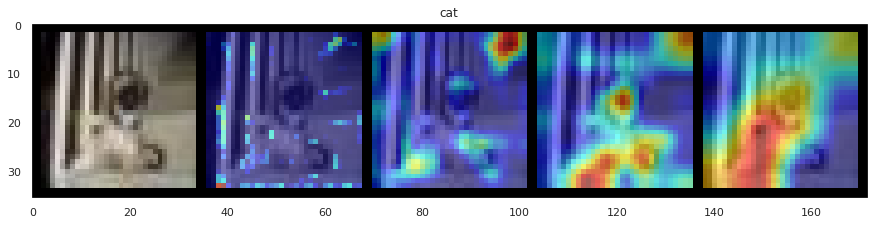

In [27]:

import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
    

  grid_image = make_grid(images2,nrow=5,padding=2,normalize=False)

  imshow1(grid_image,c = classes[int(predicted)])